Exploratory look at density of snowfall events during the season in different regions.

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import vapeplot
from scipy.stats import lognorm, expon
from math import ceil, floor
from statsmodels.graphics.gofplots import qqplot

In [2]:
sns.set_theme(context='notebook', style='whitegrid')
palname = 'vaporwave'
pal =  sns.blend_palette(vapeplot.palette(palname), n_colors=8)

In [3]:
snow_df = (pd.read_parquet('../../data/snow_data_clean.parquet', 
                         columns=['snowfall', 'region', 'pseudo_ts', 'station',
                                 'basecol_interpolated'])
           .query('basecol_interpolated==False & snowfall<=40')
           .drop(columns=['basecol_interpolated']))
snow_df.head()

,snowfall,region,pseudo_ts,station
11088,0.0,Other,1692-01-13,Mt. Holiday
11089,0.0,Other,1692-01-14,Mt. Holiday
11090,0.0,Other,1692-01-15,Mt. Holiday
11091,0.0,Other,1692-01-16,Mt. Holiday
11092,0.0,Other,1692-01-17,Mt. Holiday


In [73]:
def regional_moments(df: pd.DataFrame) -> pd.DataFrame:
    return (df.groupby(['region'],)
            .agg(mean=('snowfall', 'mean'),
                 stdv=('snowfall', 'std'))
            .reset_index(['region'])
            .sort_values(['stdv'], ascending=False)
            )

snow_dist_df = regional_moments(snow_df)
snow_dist_df

,region,mean,stdv
6,Sierras,1.512045,4.450710
7,Utah,1.751008,3.708571
0,Cascades,1.624672,3.520222
1,Colorado,1.494006,3.027847
5,Rockies_Other,1.326346,2.861909
3,New_England,0.831223,2.446666
2,East,0.654089,2.080461
4,Other,0.524662,1.839717


In [75]:
regional_moments(snow_df.query('snowfall>0'))

,region,mean,stdv
6,Sierras,7.561442,7.302373
7,Utah,5.340164,4.772843
0,Cascades,5.076368,4.604177
3,New_England,4.149916,4.014393
1,Colorado,4.242763,3.791268
5,Rockies_Other,4.142808,3.730348
2,East,3.626830,3.635909
4,Other,3.588325,3.486622


In [5]:
def snowfall_agg(df: pd.DataFrame, window: int) -> pd.DataFrame:
    """aggregates snowfall by amount per timeframe, and computes 
    total snow that fell on such units"""
    df = (df.groupby(['region', 'snowfall'])
          .agg(snowfall_freq=('snowfall', 'count'))
          .reset_index()
          .merge(right=station_counts, how='left', on='region',
                 copy=True, indicator=False,)
          .assign(snowfall_freq=lambda x: x.snowfall_freq/x.stations_in_reg)
          .assign(ln_snowfall_freq=lambda x: np.log(x.snowfall_freq))
          .eval('total_snow=snowfall*snowfall_freq')
          .assign(total_snow_grp=lambda x:
                  x.total_snow.rolling(window,  # win_type='triang',
                                       min_periods=0).mean())
          )
    # smoothed values are inaccurate on high curvature regions
    df.loc[0:window, 'total_snow_grp'] = df.loc[0:window, 'total_snow']
    return df

In [6]:
station_counts = (snow_df.groupby(['region'])
                 .agg(stations_in_reg=('station', lambda x: 
                                            np.size(x.unique()))))
snow_freq_df = (snow_df
                .pipe(snowfall_agg, 2)
               )

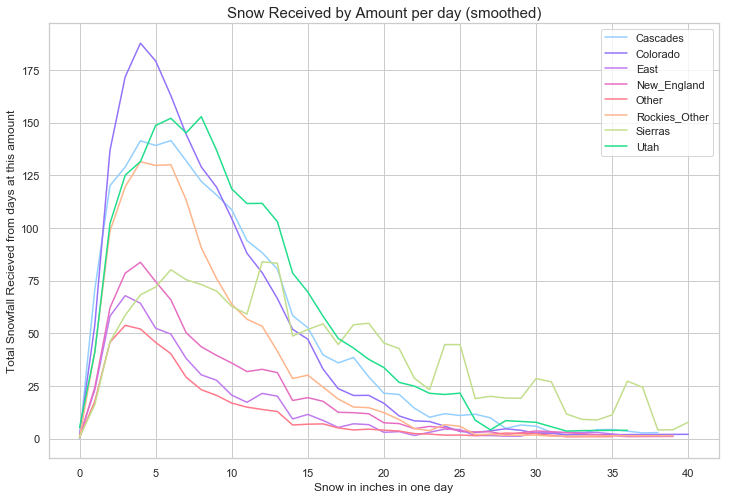

In [76]:
def snow_density_plot(df, y, freq):
    fig, ax = plt.subplots(1, figsize=(12,8))
    sns.lineplot(data=df, x='snowfall', y=y,
                 hue='region', palette=pal)
    ax.set_title(f'Snow Received by Amount per {freq} (smoothed)', size=15)
    ax.set_xlabel(f'Snow in inches in one {freq}')
    ax.set_ylabel(f'Total Snowfall Recieved from {freq}s at this amount')
    _, labels = ax.get_legend_handles_labels()
    #for i, region in enumerate(df.region.unique()):
    #    region_df = df.query('region==@region')
        # need  to get value close to where lineplot is for non-int
    #    region_mean = round(region_df[y].mean())
    #    print(region_mean)
    #    snowfall_at_mean = region_df.query('@y==@region_mean').snowfall.values
    #    print(snowfall_at_mean)
    #    labels[labels.index(region)] = region + f": {round(region_mean)}"
    #    ax.set_ylim([0, None])
    #    ylim_scale = ax.get_ylim()[1] - ax.get_ylim()[0]
    #    plt.axvline(x=region_mean,
    #               ymin=0, ymax=snowfall_at_mean/ylim_scale,
    #               color=pal[i])
    ax.legend(labels);


snow_density_plot(df=snow_freq_df, y='total_snow_grp',
                  freq='day')

This chart shows that the Sierras & Utah takes a much larger amount of their annual snowfall on single, large "Power Days". Colorado stations take much more of their snow in very frequent snowfalls of less than half a foot. It appears to follow a lognormal distribution, which I think is similar to plots of wind power generated annual at different speeds.

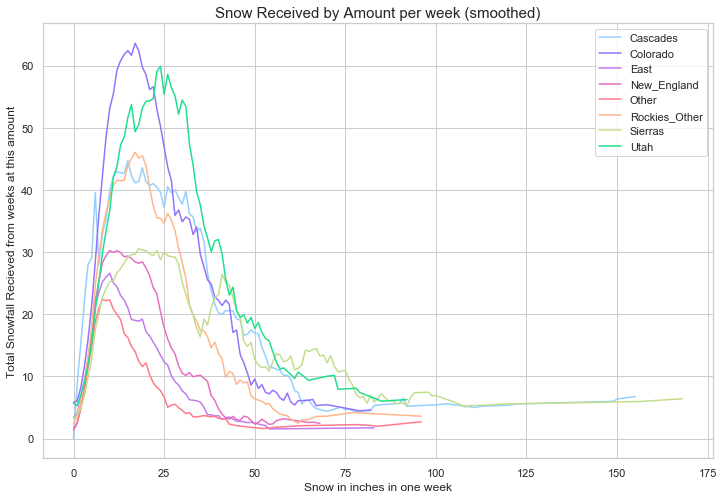

In [77]:
snow_freq_wk_df = (snow_df
                   # group snowfall by week
                   .groupby([pd.Grouper(key='pseudo_ts', freq='W-MON'),
                             'region'])
                   .agg(snowfall=('snowfall', 'sum'))
                   .pipe(snowfall_agg, 6))
snow_density_plot(snow_freq_wk_df, y='total_snow_grp', freq='week')

Very similar results for week and daily. The same patterns hold.

# Distribution analysis

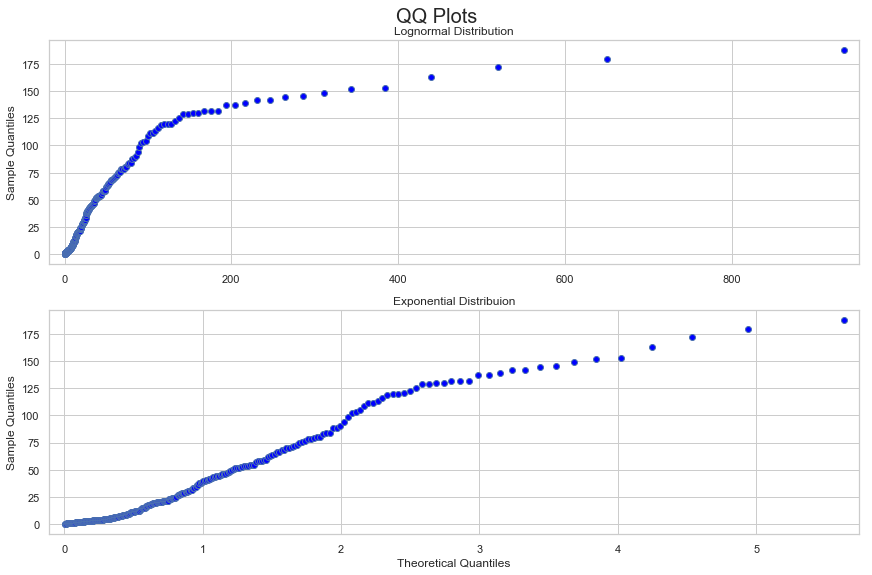

In [9]:
lnnrm_shape, lnnrm_loc, lnnrm_scale = lognorm.fit(
    snow_freq_df['total_snow_grp'].to_numpy())
exp_shape, exp_scale = expon.fit(
    snow_freq_df['total_snow_grp'].to_numpy(),)

fig, (ax0, ax1) = plt.subplots(2, 1, constrained_layout=True,
                               figsize=(12, 8))
fig = qqplot(data=snow_freq_df['total_snow_grp'], dist=lognorm, loc=lnnrm_loc,
             scale=lnnrm_scale, distargs=(lnnrm_shape,), ax=ax0)
fig = qqplot(data=snow_freq_df['total_snow_grp'], dist=expon, 
             #loc=0, scale=exp_scale, distargs=(exp_shape,),
             ax=ax1)
ax0.set_xlabel("")
ax0.set_title("Lognormal Distribution")
ax1.set_title("Exponential Distribuion")
fig.suptitle("QQ Plots", fontsize=20);

An exponential distribution actually looks like a pretty good fit.

In [10]:
snow_freq_df['total_snow_grp'].value_counts()

136.888889    1
5.027027      1
111.653846    1
0.905405      1
68.217391     1
             ..
69.538462     1
11.770270     1
9.130435      1
11.239130     1
0.000000      1
Name: total_snow_grp, Length: 278, dtype: int64

In [11]:
(snow_freq_df.query('total_snow_grp>0')
.groupby(['region'])['total_snow_grp']
        .apply(expon.fit))

region
Cascades            (1.57499999999997, 49.40202702702703)
Colorado          (1.7499999999998948, 54.07385620915035)
East              (1.111111111111006, 16.155974155974164)
New_England       (0.5135135135134221, 23.63104013104014)
Other             (0.527027027026948, 13.784219703574522)
Rockies_Other    (0.4729729729728742, 37.616201916201916)
Sierras           (0.7222222222221251, 38.97195711087548)
Utah                 (3.53846153846151, 60.3608999695956)
Name: total_snow_grp, dtype: object

In [12]:
exp_fit_df = (snow_freq_df
              .query('total_snow_grp>0')
              .groupby(['region'])['total_snow_grp']
              .apply(expon.fit).to_frame().reset_index())

# assign tuples as individual columns
exp_fit_df[['shape', 'scale']] = pd.DataFrame(exp_fit_df.total_snow_grp.tolist(),
                                              index=exp_fit_df.index)
exp_fit_df = exp_fit_df.drop(columns=["total_snow_grp"])
exp_fit_df

,region,shape,scale
0,Cascades,1.575000,49.402027
1,Colorado,1.750000,54.073856
2,East,1.111111,16.155974
3,New_England,0.513514,23.631040
4,Other,0.527027,13.784220
5,Rockies_Other,0.472973,37.616202
6,Sierras,0.722222,38.971957
7,Utah,3.538462,60.360900
